# Исследование данных о продажах игр

**Цель исследования** — выявить определяющие успешность игры закономерности, чтобы сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

### Описание данных

`Name` — название игры<br>
`Platform` — платформа<br>
`Year_of_Release` — год выпуска<br>
`Genre` — жанр игры<br>
`NA_sales` — продажи в Северной Америке (миллионы проданных копий)<br>
`EU_sales`— продажи в Европе (миллионы проданных копий)<br>
`JP_sales` — продажи в Японии (миллионы проданных копий)<br>
`Other_sales` — продажи в других странах (миллионы проданных копий)<br>
`Critic_Score` — оценка критиков (максимум 100)<br>
`User_Score` — оценка пользователей (максимум 10)<br>
`Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

In [1]:
import pandas as pd                     # импорт библиотек
import numpy as np
from scipy import stats as st
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
try:
    games = pd.read_csv('/datasets/games.csv') # чтение файла с данными и сохранение в games
except:
    games = pd.read_csv('C:\\Users\\User\\Downloads\\Games csv.csv')

In [3]:
games

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В таблице 16715 строк. Пропущенны значения в столбцах Name, Year_of_Release, Genre, User_Score, Rating. <br>
Столбец Year_of_Release нужно привести к типу datetime,  User_Score к float.<br>
Названия с столбцов необходимо привести к snake_case.

In [5]:
pd.DataFrame(games.isna().mean().round(4)*100).sort_values(by=0)[::-1].style.background_gradient('coolwarm')
# процент пропущенных значений по столбцам

,0
Critic_Score,51.320000
Rating,40.480000
User_Score,40.090000
Year_of_Release,1.610000
Genre,0.010000
Name,0.010000
Other_sales,0.000000
JP_sales,0.000000
EU_sales,0.000000
NA_sales,0.000000


In [6]:
games.columns = games.columns.str.lower()

In [7]:
games.head(1)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E


In [8]:
games.duplicated().sum()   # проверка на отсутствие явных дубликатов

0

### Обработка пропусков

In [9]:
games = games.dropna(subset=['year_of_release']) # удаляение строки с пропуском в year_of_release

Аббревиатура tbd переводится как to be decided or to be determined. Используется когда что-то ещё не решено (будет определено позднее, уточняется).<br> В games 2376 строк с такой оценкой от пользователя. Предполагаю, tbd значит, что пользователь ещё не поставил игре оценку. Заменим их на Nan.<br> Считаю, что заполнять пропуски в столбцах critic_score, rating и user_score не нужно. Пропусков слишком много и "придуманные" данные сильно исказят картину. Заполним их специальными значениями.


In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
games.loc[games['user_score'] == 'tbd','user_score'] = np.nan # замена tbd на nan

In [12]:
# Замена пропущенных значений специальными.Столбец rating имеет
# тип данных object, поэтому его заменяем на no_rating тоже object.
# в столбцах user_score и critic_score пропуски заменяем на -1.
games['rating'] = games['rating'].fillna('no_rating') 
games['user_score'] = games['user_score'].fillna(-1) 
games['critic_score'] = games['critic_score'].fillna(-1)

In [13]:
games['year_of_release'] = games['year_of_release'].astype('int') # приведение данных с столбце 
                                                                  # year_of_release к типу int.

In [14]:
games['user_score'] = games['user_score'].astype('float') # приведение данных в столбце user_score 
                                                          # к типу float.

### Исследовательский анализ данных

In [15]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
# добавляем столбец с продажами по всем регионам

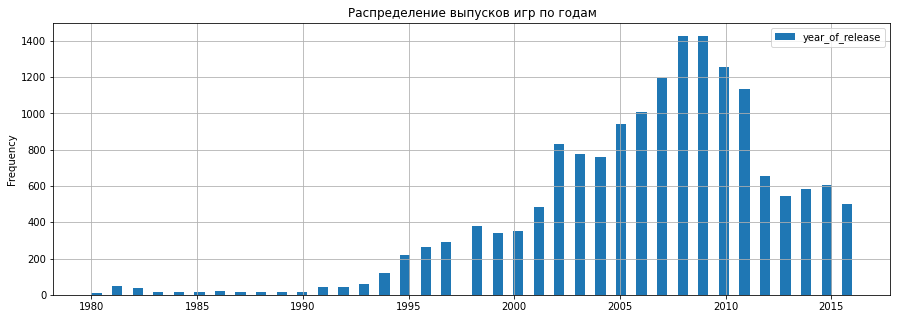

In [16]:
games.plot(kind='hist', y = 'year_of_release',bins=74, grid=True,
           title='Распределение выпусков игр по годам' , xlabel='год', figsize=(15,5)); 

С 1986 года выпуск игр с небольшими перепадами, но растет и достигает пика в 1400 выпущенных игр в 2008 и 2009 году. Далее следует спад. В 2016 году количество выпущенных игр около 500. <br>

In [17]:
games.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(20) 
# находим платформы с наибольшими суммарными продажами 

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.78
PS       727.58
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
PC       255.76
GB       254.43
XB       251.57
NES      251.05
N64      218.01
SNES     200.04
GC       196.73
XOne     159.32
2600      86.48
WiiU      82.19
Name: total_sales, dtype: float64

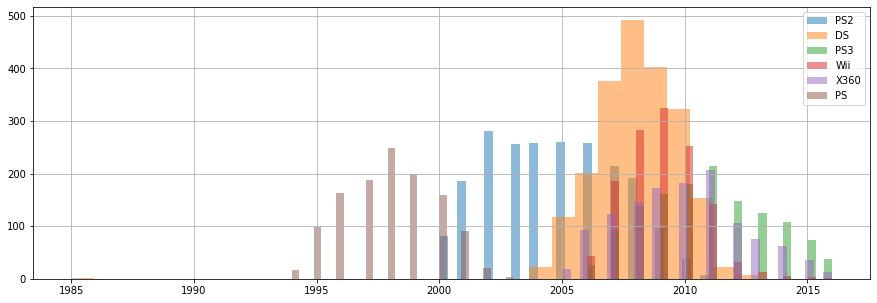

In [18]:
for platform in ['PS2', 'DS', 'PS3', 'Wii', 'X360', 'PS',]:
    games.query('platform == @platform')['year_of_release'].hist(bins=30, alpha=0.5, figsize=(15,5))
    plt.legend(['PS2', 'DS', 'PS3', 'Wii', 'X360', 'PS',])

Платформа PS появилась в 1994, её перестали выпускать в 2003 - 9 лет. <br>
Платформа X360 выпускалась с 2005 по 2016 - 11 лет. <br>
Платформа Wii выпускалась с 2006 по 2016 - 10 лет.<br>
Платформа PS3 выпускалась с 2006 по 2016 - 10 лет. <br>
Платформа DS вышла в 1985, но данные по ней вдимо начали собираться только с 2003. В 2013 на неё вышли последние игры.<br>
Платформа PS2 выпускалась с 2000 по 2011 - 11 лет.<br>
Средняя продолжительность существования платформы равна десяти годам.

In [19]:
games_2 = games.loc[games['year_of_release'] > 2013]#создание датафрейма в который входят только 
                                                             # данные за актуальный период

In [20]:
games_2.groupby('platform')['total_sales'].sum().sort_values(ascending=False) # находим платформы
                                                # с наибольшими суммарными продажами c 2013 года. 

platform
PS4     288.15
XOne    140.36
3DS      86.68
PS3      68.18
X360     48.22
WiiU     42.98
PC       27.05
PSV      22.40
Wii       5.07
PSP       0.36
Name: total_sales, dtype: float64

Самое большое количество проданных копий у платформы PS4 - 288 млн.копий, у XOne - 140 млн.копий, у 3DS - 86 млн.копий, у PS3 - 68 млн.копий, X360 - 48 млн.копий, WiiU - 42 млн.копий.

In [21]:
df_filter = games_2['platform']. isin (['PS4', 'XOne', '3DS', 'PS3', 'X360', 'WiiU']) 
games_2 = games_2[df_filter] # отберем данные по самым продаваемым платформам 

In [22]:
PS4_pivot = games_2[games_2['platform'] == 'PS4'].pivot_table(index=['year_of_release'],
            values='total_sales', aggfunc=['sum']) 
XOne_pivot = games_2[games_2['platform'] == 'XOne'].pivot_table(index=['year_of_release'],
             values='total_sales', aggfunc=['sum'])
DS_pivot = games_2[games_2['platform'] == '3DS'].pivot_table(index=['year_of_release'],
            values='total_sales', aggfunc=['sum'])
PS3_pivot = games_2[games_2['platform'] == 'PS3'].pivot_table(index=['year_of_release'],
            values='total_sales', aggfunc=['sum'])
X360_pivot = games_2[games_2['platform'] == 'X360'].pivot_table(index=['year_of_release'],
            values='total_sales', aggfunc=['sum'])
WiiU_pivot = games_2[games_2['platform'] == 'WiiU'].pivot_table(index=['year_of_release'],
            values='total_sales', aggfunc=['sum'])
# сводные таблицы для визуализации продаж по платформам

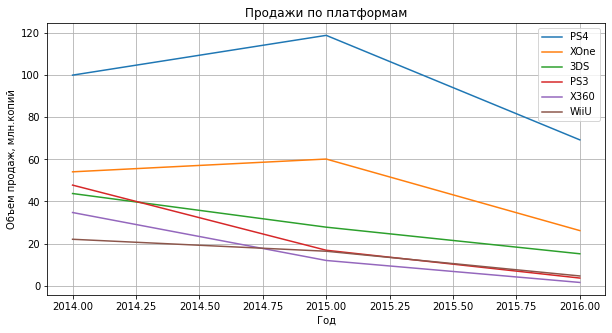

In [23]:
plt.figure(figsize=(10, 5))
plt.grid(True)
plt.plot(PS4_pivot)
plt.plot(XOne_pivot)
plt.plot(DS_pivot)
plt.plot(PS3_pivot)
plt.plot(X360_pivot)
plt.plot(WiiU_pivot)
plt.legend(['PS4', 'XOne', '3DS', 'PS3', 'X360', 'WiiU']) 
plt.ylabel('Объем продаж, млн.копий')
plt.xlabel('Год')
plt.title('Продажи по платформам');

У всех популярных платформ продажи падают. Как и весь рынок игр.

(0.0, 2.0)

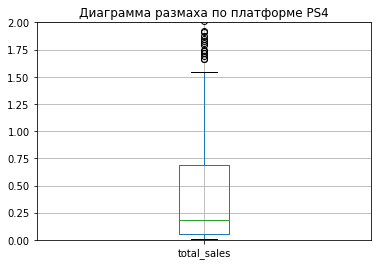

In [24]:
games_2[games_2['platform'] == 'PS4'].plot(kind='box', y='total_sales', grid=True
    , title='Диаграмма размаха по платформе PS4')# Диаграмма размаха по платформе PS4
plt.ylim(0, 2) # ограничение по оси y для большей наглядности

Среднее значение глобальных продаж составляет 0.76 млн.копий, медиана меньше 0.25 млн.копий.

(0.0, 2.0)

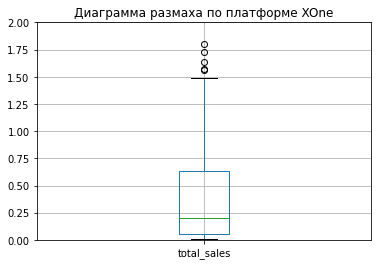

In [25]:
games_2[games_2['platform'] == 'XOne'].plot(kind='box', y='total_sales', grid=True
    , title='Диаграмма размаха по платформе XOne')# Диаграмма размаха по платформе XOne
plt.ylim(0, 2) # ограничение по оси y для большей наглядности.

Среднее значение глобальных продаж составляет 0.16 млн.копий, медиана меньше 0.25 млн.копий.

(0.0, 1.0)

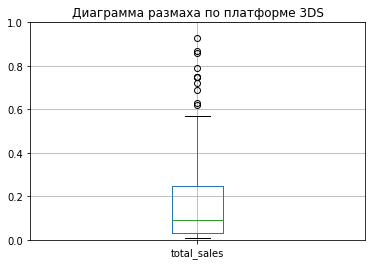

In [26]:
games_2[games_2['platform'] == '3DS'].plot(kind='box', y='total_sales', grid=True
    , title='Диаграмма размаха по платформе 3DS')# Диаграмма размаха по платформе 3DS
plt.ylim(0, 1) # ограничение по оси y для большей наглядности.

Среднее значение глобальных продаж составляет 0.40 млн.копий, медиана меньше 0.2 млн.копий.

(0.0, 2.0)

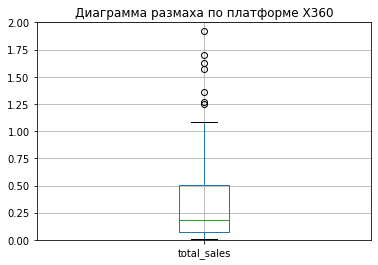

In [27]:
games_2[games_2['platform'] == 'X360'].plot(kind='box', y='total_sales', grid=True
    , title='Диаграмма размаха по платформе X360')# Диаграмма размаха по платформе X360
plt.ylim(0, 2) # ограничение по оси y для большей наглядности.

Среднее значение глобальных продаж составляет 0.40 млн.копий, медиана меньше 0.25 млн.копий

(0.0, 1.0)

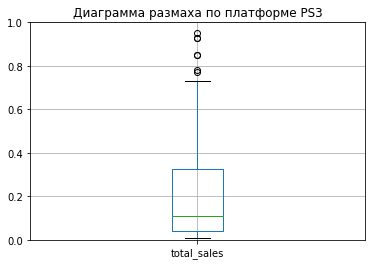

In [28]:
games_2[games_2['platform'] == 'PS3'].plot(kind='box', y='total_sales', grid=True
    , title='Диаграмма размаха по платформе PS3')# Диаграмма размаха по платформе PS3
plt.ylim(0, 1) # ограничение по оси y для большей наглядности.

Среднее значение глобальных продаж составляет 0.31 млн.копий, медиана меньше 0.20 млн.копий

(0.0, 2.0)

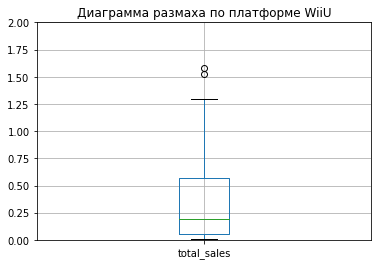

In [29]:
games_2[games_2['platform'] == 'WiiU'].plot(kind='box', y='total_sales', grid=True
    , title='Диаграмма размаха по платформе WiiU')# Диаграмма размаха по платформе WiiU
plt.ylim(0, 2) # ограничение по оси y для большей наглядности.

Среднее значение глобальных продаж составляет 0.58 млн.копий, медиана меньше 0.25 млн.копий

Среднее значение глобальных продаж составляет 0.55 млн.копий, медиана 0.14 млн.копий.

#### Диаграмма рассеяния

Для этой диаграммы возьмем данные по PS4 - платформе лидирующей по глобальным продажам в выборке с 2013 года.

In [30]:
games_PS4 = games_2[(games_2['platform'] == 'PS4') & (games_2['critic_score'] > 0)].copy()

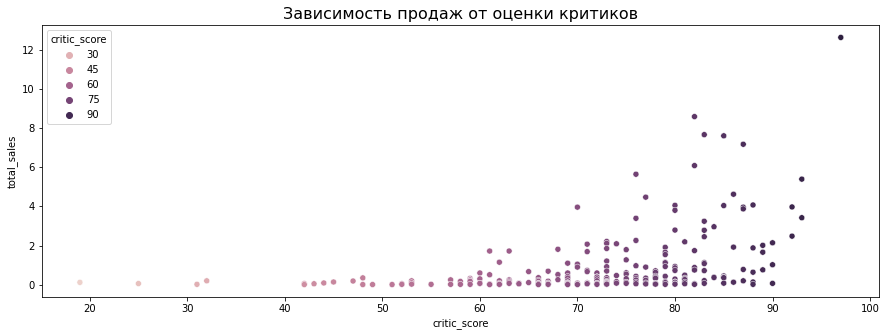

In [31]:
f, ax = plt.subplots(figsize=(15, 5))
sns.scatterplot(data=games_PS4, x="critic_score", y="total_sales"
    , hue="critic_score").axes.set_title("Зависимость продаж от оценки критиков", fontsize=16);

In [32]:
print(games_PS4['total_sales'].corr(games_PS4['critic_score'])) # найдём коэффициент корреляции

0.40266141068104083


В среднем с увеличением оценки критиков растут и продажи игр. Исходя из коэффициента корреляции можно сделать вывод, что связь меджу оценкой критиков и продажами есть, но не выраженная.

In [33]:
games_PS4_user_score = games_2[(games_2['platform'] == 'PS4') & (games_2['user_score'] > 0)].copy()

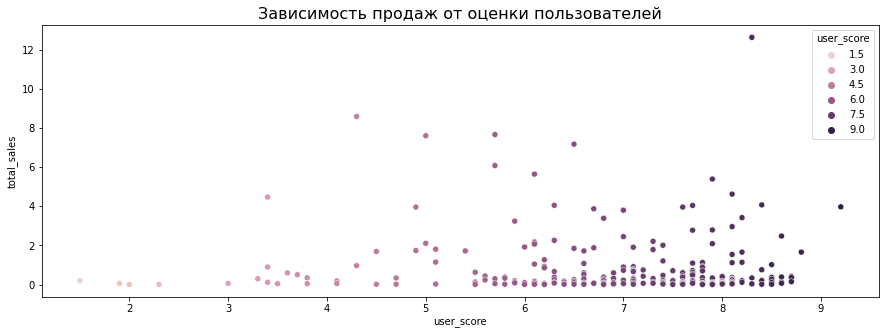

In [34]:
f, ax = plt.subplots(figsize=(15,5))
sns.scatterplot(data=games_PS4_user_score, x="user_score", y="total_sales"
    , hue="user_score").axes.set_title("Зависимость продаж от оценки пользователей", fontsize=16);

In [35]:
print(games_PS4_user_score['total_sales'].astype('float64').corr(
    games_PS4_user_score['user_score'].astype('float64')))
 # найдём коэффициент корреляции

-0.040131589472697356


Зависимости между оценкой пользователей и продажами нет.

Посчитаем корреляцию для платформ XOne, 3DS, PS3, X360, WiiU.

In [36]:
games_XOne = games_2[(games_2['platform'] == 'XOne') & (games_2['critic_score'] > 0)].copy()
print('Коэффициент корреляции оценки критиков для XOne:'
      ,games_XOne['total_sales'].corr(games_XOne['critic_score'])) 
# найдём коэффициент корреляции

Коэффициент корреляции оценки критиков для XOne: 0.42867694370333226


In [37]:
games_XOne_user_score = games_2[(games_2['platform'] == 'XOne') & (games_2['user_score'] > 0)].copy()
print('Коэффициент корреляции оценки пользователей для XOne:'
      ,games_XOne['total_sales'].corr(games_XOne['user_score'])) 
# найдём коэффициент корреляции

Коэффициент корреляции оценки пользователей для XOne: 0.007395767292791306


In [38]:
games_3DS = games_2[(games_2['platform'] == '3DS') & (games_2['critic_score'] > 0)].copy()
print('Коэффициент корреляции оценки критиков для для 3DS:'
      ,games_3DS['total_sales'].corr(games_3DS['critic_score'])) 
# найдём коэффициент корреляции

Коэффициент корреляции оценки критиков для для 3DS: 0.31411749286905105


In [39]:
games_3DS = games_2[(games_2['platform'] == '3DS') & (games_2['user_score'] > 0)].copy()
print('Коэффициент корреляции оценки пользователей для 3DS:'
      ,games_3DS['total_sales'].corr(games_3DS['user_score'])) 
# найдём коэффициент корреляции

Коэффициент корреляции оценки пользователей для 3DS: 0.2151932718527028


In [40]:
games_PS3 = games_2[(games_2['platform'] == 'PS3') & (games_2['critic_score'] > 0)].copy()
print('Коэффициент корреляции оценки критиков для PS3:'
      ,games_PS3['total_sales'].corr(games_PS3['critic_score'])) 
# найдём коэффициент корреляции

Коэффициент корреляции оценки критиков для PS3: 0.44657460493190704


In [41]:
games_PS3 = games_2[(games_2['platform'] == 'PS3') & (games_2['user_score'] > 0)].copy()
print('Коэффициент корреляции оценки пользователей для PS3:'
      ,games_PS3['total_sales'].corr(games_PS3['user_score']))
 # найдём коэффициент корреляции

Коэффициент корреляции оценки пользователей для PS3: -0.16676141347662116


In [42]:
games_X360 = games_2[(games_2['platform'] == 'X360') & (games_2['critic_score'] > 0)].copy()
print('Коэффициент корреляции оценки критиков для X360:'
      ,games_X360['total_sales'].corr(games_X360['critic_score'])) 
# найдём коэффициент корреляции

Коэффициент корреляции оценки критиков для X360: 0.5257228356581523


In [43]:
games_X360 = games_2[(games_2['platform'] == 'X360') & (games_2['user_score'] > 0)].copy()
print('Коэффициент корреляции оценки пользователей для X360:'
      ,games_X360['total_sales'].corr(games_X360['user_score']))
 # найдём коэффициент корреляции

Коэффициент корреляции оценки пользователей для X360: -0.138444570945665


In [44]:
games_WiiU = games_2[(games_2['platform'] == 'WiiU') & (games_2['critic_score'] > 0)].copy()
print('Коэффициент корреляции оценки критиков для WiiU:'
      ,games_WiiU['total_sales'].corr(games_WiiU['critic_score'])) 
# найдём коэффициент корреляции

Коэффициент корреляции оценки критиков для WiiU: 0.370201412480884


In [45]:
games_WiiU = games_2[(games_2['platform'] == 'WiiU') & (games_2['user_score'] > 0)].copy()
print('Коэффициент корреляции оценки пользователей для WiiU:'
      ,games_WiiU['total_sales'].corr(games_WiiU['user_score']))
 # найдём коэффициент корреляции

Коэффициент корреляции оценки пользователей для WiiU: 0.4079264579217078


По всем платформам оценка критиков сильнее влияет на продажи, чем оценка пользователей. Самая высокая корреляция у платформы PS3.

#### Распределение игр по жанрам

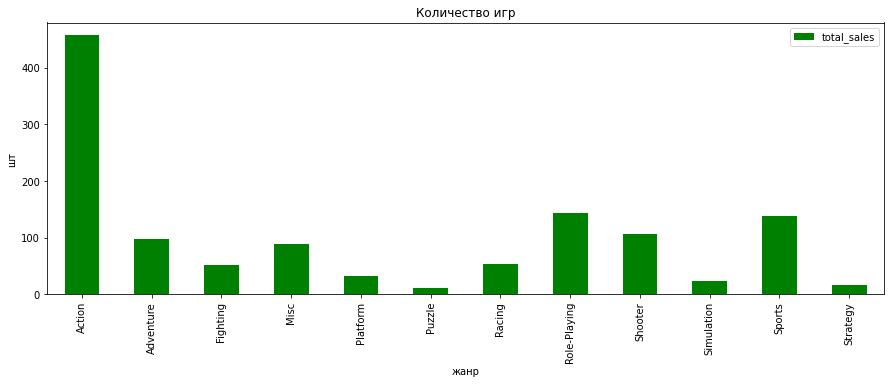

In [46]:
pivot_count = games_2.pivot_table(index = 'genre', values = 'total_sales', aggfunc = ['count'])
pivot_count.plot(kind='bar', y='count', figsize = (15, 5), ylabel = 'шт',
                 xlabel='жанр', title='Количество игр', color = 'g');

Больше всего игр выпускают в жанре Action, Role-Playing, Sports и Shooter,  меньше всего игр в жанре Strategy, Simulation, Puzzle. 

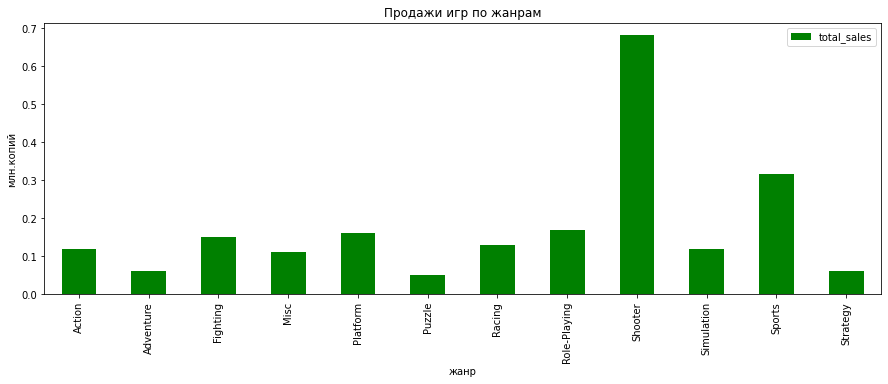

In [47]:
pivot = games_2.pivot_table(index = 'genre', values = 'total_sales', aggfunc = ['median'])
pivot.plot(kind='bar', y='median', figsize = (15, 5), ylabel = 'млн.копий', xlabel='жанр'
           , title='Продажи игр по жанрам', color = 'g');

Стабильно приносят высокий доход игры в жанре Shooter и Sports.

Можно выделить игры в жанре Shooter. Количественно их не очень много, но они продаются большим количеством копий. 


####  Портрет пользователя для каждого региона

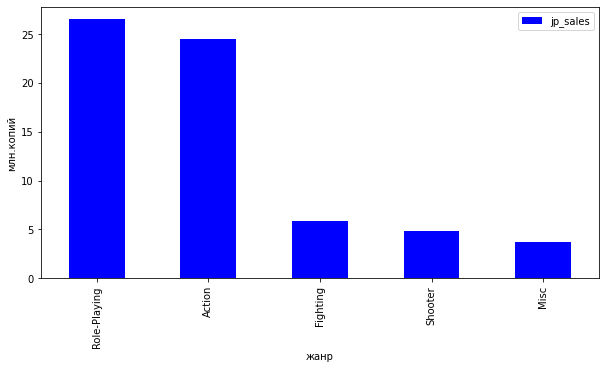

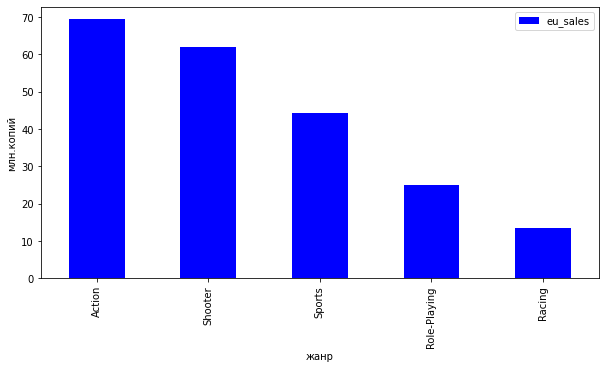

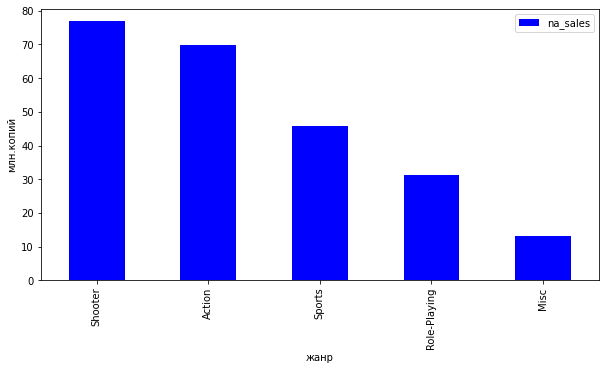

In [48]:
games_2.groupby(by='genre').agg({'jp_sales':'sum'}).sort_values(by='jp_sales'
, ascending=False).head(5).plot(kind='bar', figsize=(10,5), ylabel='млн.копий',
xlabel='жанр', color = 'b');
games_2.groupby(by='genre').agg({'eu_sales':'sum'}).sort_values(by='eu_sales',
ascending=False).head(5).plot(kind='bar', figsize=(10,5), ylabel='млн.копий',
xlabel='жанр', color = 'b');
games_2.groupby(by='genre').agg({'na_sales':'sum'}).sort_values(by='na_sales',
ascending=False).head(5).plot(kind='bar', figsize=(10,5), ylabel='млн.копий',
xlabel='жанр', color = 'b');

Рынок игр в Японии сильно отличается от рынка Северной Америки и Европы. Самыми популярными играми в Японии являются игры в жанре role-playing. Далее идут action, fighting, shooter и misc. 
В Северное Америке и в Европе похожие рынки игр. В топ-4 входят одинаковые жанры. Но в Европе больше любят racing, а в Северной Америке misc. 

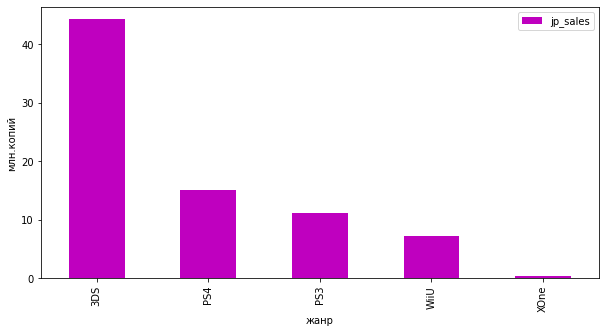

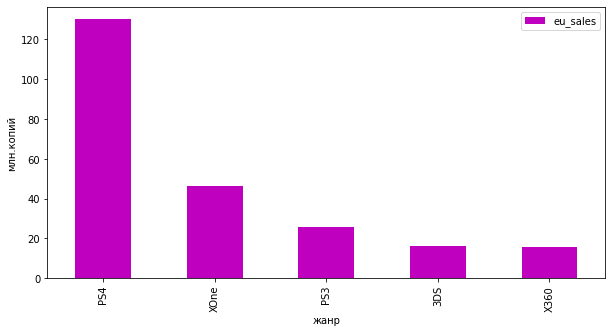

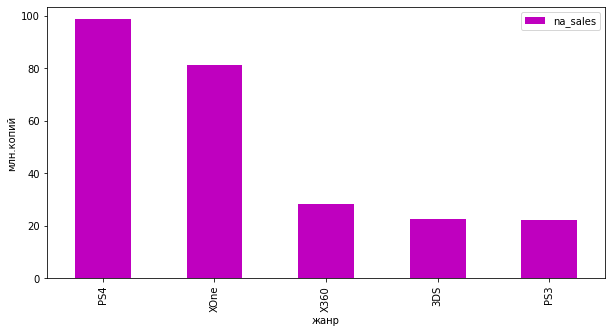

In [49]:
games_2.groupby(by='platform').agg({'jp_sales':'sum'}).sort_values(by='jp_sales', ascending=False
    ).head(5).plot(kind='bar', figsize=(10,5), ylabel='млн.копий', xlabel='жанр', color = 'm');
games_2.groupby(by='platform').agg({'eu_sales':'sum'}).sort_values(by='eu_sales', ascending=False
    ).head(5).plot(kind='bar', figsize=(10,5), ylabel='млн.копий', xlabel='жанр', color = 'm');
games_2.groupby(by='platform').agg({'na_sales':'sum'}).sort_values(by='na_sales', ascending=False
    ).head(5).plot(kind='bar' , figsize=(10,5), ylabel='млн.копий', xlabel='жанр', color = 'm');

В топе Северной Америки и Европы одни и те же платформы. Немного по-разному расположены по местам. <br>
В Японии представлена приставка WIIU, которая не попала в топ-5 Северной Америки и Европы. Х360 не попала в топ в Японии.

In [50]:
# games_rating = games_2[(games_2['rating'] != 'no_rating')].copy() # фильтруем по играм с рейтингом

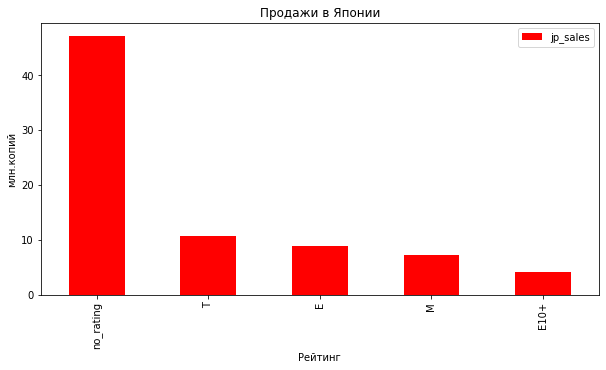

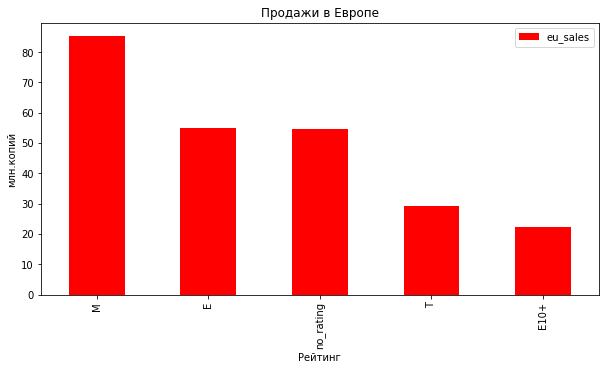

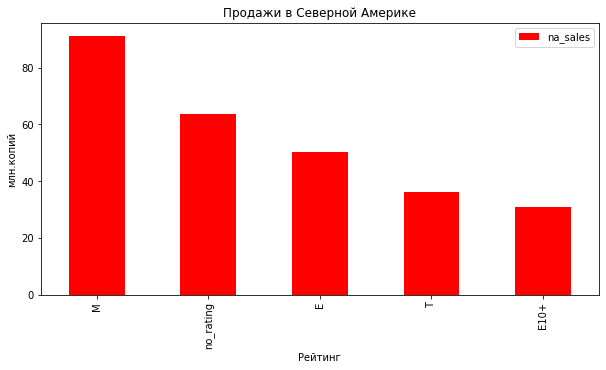

In [51]:
games_2.groupby(by='rating').agg({'jp_sales':'sum'}).sort_values(by='jp_sales', ascending=False
    ).head(5).plot(kind='bar', figsize=(10,5), ylabel='млн.копий', xlabel='Рейтинг', color = 'r',
    title='Продажи в Японии');
games_2.groupby(by='rating').agg({'eu_sales':'sum'}).sort_values(by='eu_sales', ascending=False
    ).head(5).plot(kind='bar' , figsize=(10,5), ylabel='млн.копий', xlabel='Рейтинг', color = 'r',
    title='Продажи в Европе');
games_2.groupby(by='rating').agg({'na_sales':'sum'}).sort_values(by='na_sales', ascending=False
    ).head(5).plot(kind='bar', figsize=(10,5), ylabel='млн.копий', xlabel='Рейтинг', color = 'r', 
    title='Продажи в Северной Америке');

Игры без рейтинга входят в топ самых продаваемых во всех рассматриваемых регионах. В Японии на первом месте, в Северной Америке на втором, в Европе на третьем. Игры с рейтингом M ("Для взрослых") лидируют в топе Северной Америки и Европы.


### Проверка гипотез

#### Гипотеза 1

H₀ - cредние пользовательские рейтинги платформ Xbox One и PC одинаковые.<br>
H₁ - cредние пользовательские рейтинги платформ Xbox One и PC различаются.

In [52]:
games_3 = games.loc[games['year_of_release'] > 2013]

In [53]:
XOne = games_3[(games_3['platform'] == 'XOne') & (games_3['user_score'] > 0)]['user_score']
PC = games_3[(games_3['platform'] == 'PC') & (games_3['user_score'] > 0)]['user_score']
alpha = .05

results = st.ttest_ind(
    XOne, 
    PC, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.11601398086668827
Не получилось отвергнуть нулевую гипотезу


Верной следует считать гипотезу о том, что cредние пользовательские рейтинги платформ Xbox One и PC одинаковые.

#### Гипотеза 2

H₀ - средние пользовательские рейтинги жанров Action и Sports одинаковые.<br>
H₁ - средние пользовательские рейтинги жанров Action и Sports различаются.

In [54]:
Action = games_3[(games_3['genre'] == 'Action') & (games_3['user_score'] > 0)]['user_score']
Sports = games_3[(games_3['genre'] == 'Sports') & (games_3['user_score'] > 0)]['user_score']
alpha = .05

results = st.ttest_ind(
    Action, 
    Sports, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.1825550382644557e-14
Отвергаем нулевую гипотезу


У нас нет оснований утверждать, что средние пользовательские рейтинги жанров Action и Sports одинаковые. Средние пользовательские рейтинги жанров Action и Sports различаются.

### Общий вывод

Для выявления определяющих успешность игры закономерностей было проведено исследование данных о продажах игр до 2016 года в Европе, Северной Америке и Японии. Данные до 2013 года из исследования убрали, чтобы устаревшая информация не искажала результаты исследования.

В целом весь рынок игровой индустрии показывает спад, поэтому особенно важно сделать ставку на самые продаваемые игры.

По исследованным данным можно сделать вывод о том, что одну стратегию для разных рынков использовать нельзя. Стратегии для Европы и Северной Америки можно объединить из-за схожести предпочтений пользователей, однако для Японии рекомендации будут отличаться.

__Япония:__<br>

Интернет-магазину Стримчик для продажи игр в Японии следует сделать ставку на игры в жанре role-playing, action, fighting, shooter выходящих на платформе 3DS без жанра.<br>

__Северная Америка и Европа:__<br>

В Северной Америке и Европе хорошо продаются игры в жанрах Shooter, Action и Sports на платформах PS4 и XOne с рейтингом M ("Для взрослых")<br>